# Dataset Visualisation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

In [3]:
import skimage
from scipy.ndimage import zoom
print(skimage.__version__)
print(cc3d)

ImportError: No module named 'skimage'

In [17]:
# Patchify lib
import numpy as np
from skimage.util import view_as_windows
from itertools import product
from typing import Tuple


def patchify(patches: np.ndarray, patch_size: Tuple[int, int], step: int = 1):
    return view_as_windows(patches, patch_size, step)


def unpatchify(patches: np.ndarray, imsize: Tuple[int, int]):

    assert len(patches.shape) == 4

    i_h, i_w = imsize
    image = np.zeros(imsize, dtype=patches.dtype)
    divisor = np.zeros(imsize, dtype=patches.dtype)

    n_h, n_w, p_h, p_w = patches.shape

    # Calculat the overlap size in each axis
    o_w = (n_w * p_w - i_w) / (n_w - 1)
    o_h = (n_h * p_h - i_h) / (n_h - 1)

    # The overlap should be integer, otherwise the patches are unable to reconstruct into a image with given shape
    assert int(o_w) == o_w
    assert int(o_h) == o_h

    o_w = int(o_w)
    o_h = int(o_h)

    s_w = p_w - o_w
    s_h = p_h - o_h

    for i, j in product(range(n_h), range(n_w)):
        patch = patches[i,j]
        image[(i * s_h):(i * s_h) + p_h, (j * s_w):(j * s_w) + p_w] += patch
        divisor[(i * s_h):(i * s_h) + p_h, (j * s_w):(j * s_w) + p_w] += 1

    return image / divisor

## Resampled and normalised data

In [7]:
# load scan
mr1 = np.load('./data/visceral_full/train/10000063_3_MRT1_wb.npz')['data']

# mr1 = np.load('./data/visceral_full/train/10000131_1_CTce_ThAb.npz')['data']
print(mr1.shape)
print(mr1.mean(), mr1.std()) # almost 0
print(np.max(mr1), np.min(mr1))

(1880, 162, 505)
1.3499068321300007e-16 1.0000000000000042


In [62]:
# load seg
mr1_seg = np.load('./data/visceral_full/train/annotations/10000131_1_CTce_ThAb.npz')['data']
print(mr1_seg.shape)

(624, 322, 322)


-1.3004511835908024 10.622279277254487


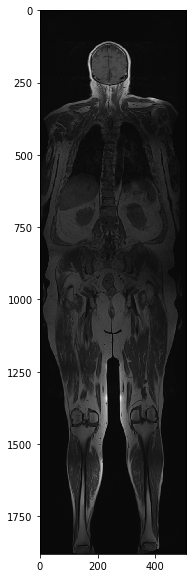

In [10]:
i = 90
# print(np.unique(mr1_seg))
plt.figure(figsize=(10, 10))
plt.imshow(np.flip(mr1[:,i,:]))
# plt.imshow(mr1_seg[:, i, :], cmap="summer", alpha=0.7)
plt.show()

In [27]:
print(1 | 0)

1


In [74]:
# Crop scan
# from sklearn.feature_extraction import image

seg_not_zero = np.where((mr1_seg != 0) & (mr1_seg != 1))

try:
    assert(len(seg_not_zero) == 3)
    assert(seg_not_zero[0].shape[0] > 0)
except:
    print('something went wrong')
    
x_bounds = (np.min(seg_not_zero[0]), np.max(seg_not_zero[0]))
y_bounds = (np.min(seg_not_zero[1]), np.max(seg_not_zero[1]))
z_bounds = (np.min(seg_not_zero[2]), np.max(seg_not_zero[2]))

print(x_bounds, y_bounds, z_bounds)
mr1_cropped = mr1[x_bounds[0]: x_bounds[1], y_bounds[0]: y_bounds[1], z_bounds[0]: z_bounds[1]]

print(mr1_cropped.shape)

dim = 256
x_width = x_bounds[1] - x_bounds[0]
z_width = z_bounds[1] - z_bounds[0]

if (x_width < dim):
    pad = ((dim-x_width) // 2) + 1
    mr1_cropped = mr1[x_bounds[0] - pad : x_bounds[1] + pad, y_bounds[0]: y_bounds[1],:]
    
    x_width, _, _ = mr1_cropped.shape
    
    if (x_width < dim):
        pad = ((dim-x_width) // 2) + 1
        padding=((pad, pad), (0,0), (0,0))
        mr1_cropped = np.pad(mr1_cropped, padding, mode='constant',constant_values=0)
    
if (z_width < dim):
    
    pad = ((dim - z_width) // 2) + 1
        
    mr1_cropped = mr1_cropped[:, :, (z_bounds[0] - pad): (z_bounds[1] + pad)]
    
    _, _, z_width = mr1_cropped.shape
    
    if (z_width < dim):
        pad = ((dim - z_width) // 2) + 1
        padding=((0,0), (0,0), (pad, pad))
        mr1_cropped = np.pad(mr1_cropped, padding, mode='constant',constant_values=0)

print(mr1_cropped.shape)

(54, 623) (65, 232) (40, 288)
(569, 167, 248)
(569, 167, 248) 569 248
before  (569, 167, 248)
35 293
213
(569, 167, 257)


(569, 167, 257)
(569, 257)


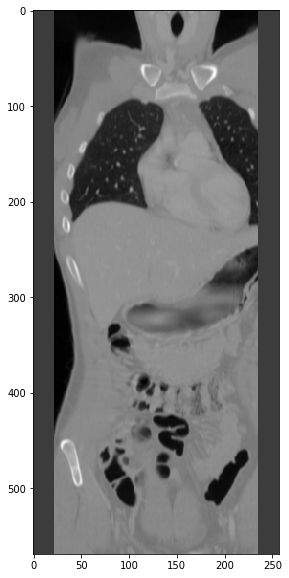

In [70]:
print(mr1_cropped.shape)
print(mr1_cropped[:,40,:].shape)
plt.figure(figsize=(10, 10))
plt.imshow(np.flip(mr1_cropped[:,40,:]))
plt.show()

In [10]:
def resize_img(img, size=256):
    x, y = img.shape
    return zoom(img, (size/x, size/y))

(548, 284)
(5, 1, 256, 256)
(5, 256, 256)


/Users/muhammad/anaconda3/lib/python3.6/site-packages/skimage/util/shape.py:246: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


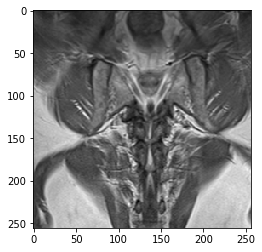

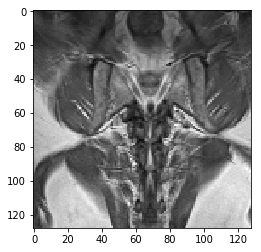

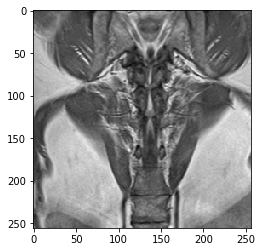

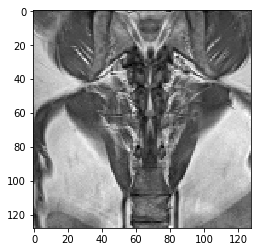

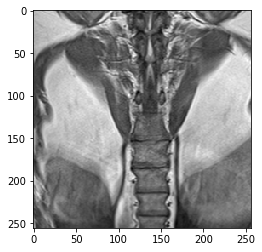

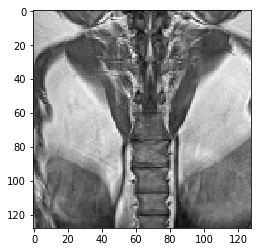

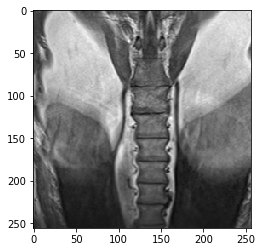

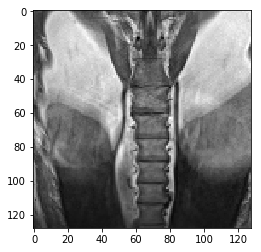

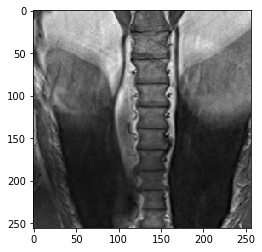

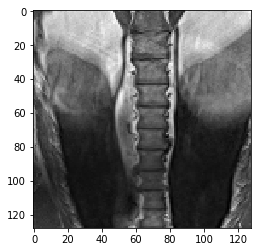

In [11]:
print(mr1_cropped[:,0,:].shape)
patches = patchify(mr1_cropped[:,100,:], (256, 256), step=64)

print(patches.shape)
print(patches.reshape(-1, patches.shape[2], patches.shape[3]).shape)

for patch_row in patches:
    for patch_col in patch_row:
        plt.imshow(patch_col)
        plt.show()
        plt.imshow(resize_img(patch_col, 128))
        plt.show()

In [35]:
# get bounds

def get_bounds(seg):
    seg_not_zero = np.where(seg != 0)
    x_bounds = (np.min(seg_not_zero[0]), np.max(seg_not_zero[0]))
    y_bounds = (np.min(seg_not_zero[1]), np.max(seg_not_zero[1]))
    z_bounds = (np.min(seg_not_zero[2]), np.max(seg_not_zero[2]))
    return x_bounds, y_bounds, z_bounds


In [36]:
# Connected components
print(mr1_seg.shape)
print(len(np.where(mr1_seg!=0)[0]))
labels_out = cc3d.connected_components(mr1_seg)
print(labels_out.shape)

(1320, 419, 419)
10430856
(1320, 419, 419)


In [4]:
from skimage import measure

blobs_labels = measure.label(mr1_seg, background=0)

NameError: name 'mr1_seg' is not defined

In [46]:
print(np.min(mr1_seg), np.max(mr1_seg), np.unique(mr1_seg))
print(blobs_labels.shape, np.min(blobs_labels), np.max(blobs_labels), np.unique(blobs_labels))

0 223 [  0   1   4   6   8   9  10  11  13  19  20  21  23  37 132 223]
(1320, 419, 419) 0 27 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


In [49]:
blobs_without_one = blobs_labels.copy()
blobs_without_one[blobs_without_one==1] = 0
print(get_bounds(blobs_without_one))

((435, 1056), (65, 315), (57, 368))


In [15]:
print(get_bounds(labels_out))

((0, 1893), (0, 155), (0, 508))


In [99]:
b = np.dstack(seg_not_zero)[0]
print(b)

[[   0  153    0]
 [   0  153    1]
 [   0  153    2]
 ...
 [1893  155  506]
 [1893  155  507]
 [1893  155  508]]


In [79]:
print(np.amin(mr1_seg, axis=0).shape, np.amax(mr1_seg, axis=0).shape)

(156, 509) (156, 509)


In [73]:
print(np.min(np.array(a)))
print(np.max(np.array(a)))

0
1893


In [59]:
a = zip([1,2], [3,4], [5,6])
print(np.min(np.array(list(a))))

1


# How does the data look like


In [3]:
from PIL import Image

In [4]:
"""
10000011_1_CT_wb_1000.npz
10000011_1_CT_wb_1200.npz
10000011_1_CT_wb_800.npz
10000082_1_CT_wb_1000.npz
10000085_1_CT_wb_1000.npz
10000111_1_CTce_ThAb_1000.npz
"""

ct_slice = np.load('10000016_1_CT_wb_1000.npz')['data']
pil_ct_slice = Image.fromarray(ct_slice)



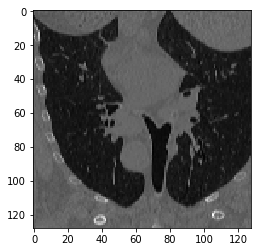

In [5]:
plt.imshow(ct_slice)
plt.show()

In [53]:
im = Image.open("test.tiff")
print(im)

<PIL.TiffImagePlugin.TiffImageFile image mode=F size=128x128 at 0x7FE5BE615BE0>


-1.179745946342915 3.3079922775642934
0.1557674463751353 0.6473966304468947


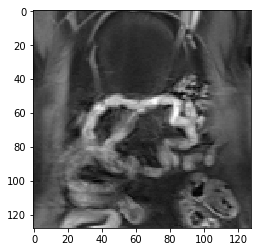

In [8]:
"""
10000083_3_MRT1_wb_947.npz
10000093_3_MRT1_wb_1000.npz
10000359_4_MRT1cefs_Ab_90.npz
"""

mr_slice = np.load('10000359_4_MRT1cefs_Ab_90.npz')['data']
print(np.min(mr_slice), np.max(mr_slice))
print(mr_slice.mean(), mr_slice.std()) # almost 0
plt.imshow(mr_slice)
plt.show()